In [1]:
# %load init.py
import os
import pickle
import sys
# Enable module import from the parent directory from notebooks
sys.path.append(os.path.abspath('..'))
import time

import matplotlib as mpl
# Select plotting backend
mpl.use('nbAgg')

import matplotlib.pyplot as plt
# Customize plotting
plt.style.use('seaborn-paper')
plt.rcParams['axes.labelsize'] = 11.0
plt.rcParams['axes.titlesize'] = 12.0
plt.rcParams['errorbar.capsize'] = 3.0
plt.rcParams['figure.dpi'] = 72.0
plt.rcParams['figure.titlesize'] = 12.0
plt.rcParams['legend.fontsize'] = 10.
plt.rcParams['lines.linewidth'] = 1.
plt.rcParams['xtick.labelsize'] = 11.0
plt.rcParams['ytick.labelsize'] = 11.0

import numpy as np
import sympy as sp
sp.init_printing(euler=True, use_latex=True)

from IPython import display
from scipy import io, optimize
from sklearn import metrics

import core
import dynamicals
import kernels
import numericals
import utils

In [2]:
dynamical = dynamicals.ProteinSignallingTransductionWithoutKm()

In [3]:
num_repetitions = 10
directory = '../data/protein-parital/{}/'
config_filename = utils.CONFIG_FILENAME
data_filename = utils.DATA_FILENAME

<IPython.core.display.Javascript object>


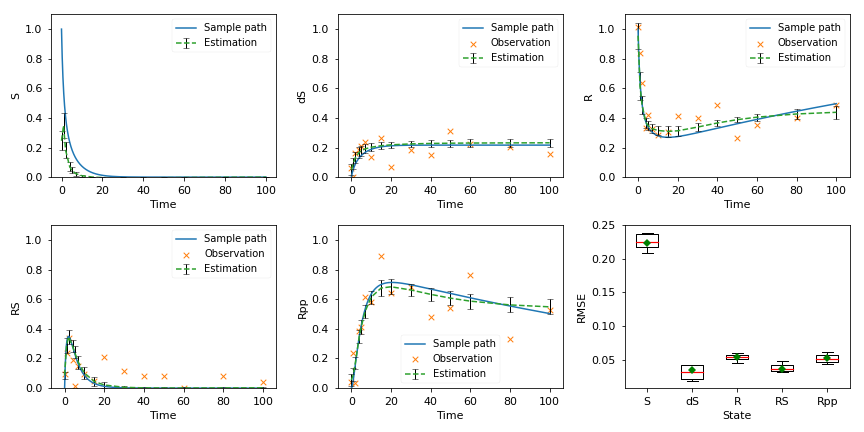

In [7]:
data = []
spl_Xs = []
for repetition in range(1, num_repetitions + 1):
    tmp = utils.load_data(directory.format(repetition), data_filename.format(repetition))
    data.append(tmp)
    
    (spl_t_0, spl_t_T, spl_tps, spl_freq,
     obs_t_0, obs_t_T, obs_freq, obs_tps, obs_t_indices,
     est_t_0, est_t_T, est_freq, est_tps, est_t_indices,
     X_0, theta, rho_2, phi, sigma_2, delta, gamma,
     opt_method, opt_tol, max_init_iter, max_iter, plotting_enabled, plotting_freq,
     spl_X, obs_Y) = utils.load_ode_config(directory.format(repetition), config_filename)     
    spl_Xs.append(spl_X)

X_mean = utils.get_X_mean(data)
X_var = utils.get_X_var(data)

figure = plt.figure(figsize=(12, 6))
for i in range(5):

    ax = figure.add_subplot(2, 3, i + 1)
    ax.plot(spl_tps, spl_X[i], color='C0', linewidth=1.5, label='Sample path')
    if delta[i]:
        ax.scatter(obs_tps, obs_Y[i], color='C1', marker='x', label='Observation')
    ax.errorbar(est_tps, X_mean[i], color='C2', linestyle='--', linewidth=1.5,
                yerr=np.sqrt(X_var[i]), ecolor='0', elinewidth=1., capsize=3., capthick=.5, label='Estimation')    
    ax.set_ylabel(dynamical.x_labels[i])
    ax.set_xlabel('Time')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels, loc=0) 
    ax.set_ylim([0, 1.1])
    
boxprops = dict(linestyle='-', linewidth=1., color='0')
medianprops = dict(linestyle='-', linewidth=1.2, color='red')
meanpointprops = dict(marker='D', markersize=6., markeredgecolor='green', markerfacecolor='green')

rmse = []
for i in range(5):
    rmse_i = []    
    for j in range(num_repetitions):                   
        rmse_i.append(metrics.mean_squared_error(data[j]['eta_X'][i], spl_Xs[j][i][est_t_indices]))
    rmse_i = np.sqrt(rmse_i)
    rmse.append(rmse_i)
        
ax = figure.add_subplot(2, 3, 6)
ax.boxplot(rmse, labels=dynamical.x_labels, notch=False, showfliers=False, showmeans=True, 
           boxprops=boxprops, medianprops=medianprops, meanprops=meanpointprops, whis=[5, 95])  
ax.set_xlabel('State')
ax.set_ylabel('RMSE')


figure.tight_layout()
plt.show()    

figure.savefig('protein-states-partial-without-km.eps', format='eps', dpi=1000, bbox_inches='tight')

<IPython.core.display.Javascript object>


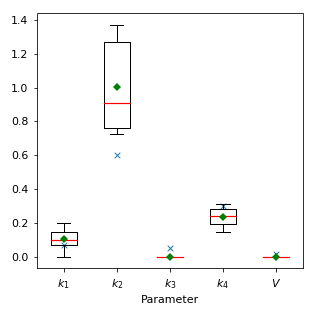

In [8]:
parameters = []
parameters_true = []
for i in range(5):
    parameters_i = []    
    for j in range(num_repetitions):                   
        parameters_i.append(data[j]['eta_theta'][i])
    parameters.append(parameters_i)    
    

figure = plt.figure(figsize=plt.figaspect(1))
ax = figure.add_subplot(1, 1, 1)
labels = ['$' + label + '$' for label in dynamical.theta_labels]
ax.boxplot(parameters, labels=labels, notch=False, showfliers=False, showmeans=True, 
           boxprops=boxprops, medianprops=medianprops, meanprops=meanpointprops, whis=[5, 95])        
ax.set_xlabel('Parameter')
j = 0
for i in ax.get_xticks():
    ax.scatter(i, theta[j], color='C0', marker='x')
    j += 1


figure.tight_layout()
plt.show()    

figure.savefig('protein-parameters-partial-without-km.eps', format='eps', dpi=1000, bbox_inches='tight')

In [ ]:
np.array(parameters).shape

In [ ]:
figure = plt.figure(figsize=plt.figaspect(1.2 / 4))

bar_width = 0.3
bar_indices = np.arange(theta.size)
ax = figure.add_subplot(1, 3, 1)
ax.bar(bar_indices, theta, bar_width, color='C0', label='Truth')
ax.bar(bar_indices + bar_width, utils.get_theta_mean(data), bar_width, color='C2', label='Estimation',
               yerr=2 * np.sqrt(utils.get_theta_var(data)),
               error_kw=dict(ecolor='0.2', capsize=4., capthick=1.))
ax.set_ylabel('Value')
ax.set_title('Theta')
ax.set_xticks(bar_indices + bar_width / 2)
ax.set_xticklabels([r'${}$'.format(label) for label in dynamical.theta_labels])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc=0)

X_mean = utils.get_X_mean(data)
X_var = utils.get_X_var(data)
for i in range(dynamical.num_x):
    ax = figure.add_subplot(1, 3, 2 + i)
    ax.plot(spl_tps, spl_X[i], color='C0', linestyle='--', linewidth=1.5, label='Sample path')
    ax.scatter(obs_tps, obs_Y[i], color='C1', marker='.', linewidth=1.5, label='Observation')
    ax.errorbar(est_tps, X_mean[i], color='C2', label='Estimation', 
                yerr=2 * np.sqrt(X_var[i]), ecolor='0.2', capsize=3., capthick=1.)
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.set_title(r'State ${}$'.format(dynamical.x_labels[i]))
    ax.set_xlim([spl_t_0, spl_t_T])
    ax.set_ylim([0, None])
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels, loc=0)

plt.show()

In [ ]:
figure = plt.figure()
ax = plt.gca()
ax.plot(spl_tps, spl_X[0], color='C0', linestyle='--', linewidth=1.5, label='Sample path')
ax.boxplot(np.array([item['eta_X'][0] for item in data]), notch=False, sym='', positions=est_tps, 
           widths=0.02, meanline=False, showmeans=False, showfliers=False)
ax.set_xlim([spl_t_0, spl_t_T])
ax.set_ylim([0, None])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc=0)
figure.show()

In [ ]:
# Helper to transform the Lotka-Volterra experiment using VGMGP 
spl_t_0, spl_t_T, spl_freq = 0, 2, 100
obs_t_0, obs_t_T, obs_freq = 0, 2, 10
est_t_0, est_t_T, est_freq = 0, 2, 10
spl_tps, obs_tps, obs_t_indices, est_tps, est_t_indices = utils.create_time(
    spl_t_0, spl_t_T, spl_freq, obs_t_0, obs_t_T, obs_freq, est_t_0, est_t_T, est_freq)
X_0 = np.array([5., 3.]) 
theta = np.array([2., 1., 1., 4.]) 
rho_2 = None
phi = [
    # (Kernal name, Kernal parameters)
    ('rbf', np.sqrt([2.5, 0.02])),
    ('rbf', np.sqrt([2.5, 0.02]))
]
sigma_2 = np.array([0.1, 0.1]) 
delta = np.full(2, True)
gamma = np.array([5e-3, 5e-3]) 

opt_method = 'Newton-CG'
opt_tol = 1e-6
max_init_iter = None
max_iter = 2000

plotting_enabled = False
plotting_freq = 50
plotting_config = None

for repetition in range(1, num_repetitions + 1):
    with open(os.path.join(directory.format(repetition), 'lpmf.mat'), 'rb') as infile:
        config_mat = io.loadmat(infile)

        spl_X = config_mat['spl_X']
        obs_Y = config_mat['obs_Y']
    
    utils.save_ode_config(directory.format(repetition), config_filename,
                          spl_t_0, spl_t_T, spl_freq, spl_tps,
                          obs_t_0, obs_t_T, obs_freq, obs_tps, obs_t_indices,
                          est_t_0, est_t_T, est_freq, est_tps, est_t_indices,
                          X_0, theta, rho_2, phi, sigma_2, delta, gamma,
                          opt_method, opt_tol, max_init_iter, max_iter,
                          plotting_enabled, plotting_freq, spl_X, obs_Y)   

In [ ]:
# Helper to check that the result are matching
for repetition in range(1, num_repetitions + 1):
    with open(os.path.join(directory.format(repetition), 'lpmf.mat'), 'rb') as infile:
        config_mat = io.loadmat(infile)    

    config_i = utils.load_data(directory.format(repetition), config_filename)
    
    assert np.alltrue(config_mat['spl_X'] == config_i['spl_X'])
    
    with open(os.path.join(vgmgp_directory.format(repetition), vgmgp_config_filename), 'rb') as infile:
        config_mat_original = io.loadmat(infile)
        
    assert np.alltrue(config_mat['spl_X'] == config_mat_original['spl_X'])
    
    for j in range(repetition, num_repetitions + 1):
        config_j = utils.load_data(directory.format(j), config_filename)
        if repetition == j:
            assert np.all(config_i['obs_Y'] == config_j['obs_Y'])
        else:
            assert np.any(config_i['obs_Y'] != config_j['obs_Y'])        